# Is there any relationship between suicides and forest area?

Required tools and libraries in this analysis:

In [3]:
import pandas as pd
import basedosdados as bd
from matplotlib import pyplot as plt

%matplotlib inline

## Available data
### To approach this question we'll consider the following datasets:
#### 1. [Sistema de Informações sobre Mortalidade (SIM)](https://basedosdados.org/dataset/br-ms-sim?bdm_table=microdados)
CID-10 codes of interest: X60-X84 e Y87.0 

#### 2. [Censo Agropecuário](https://basedosdados.org/dataset/br-ibge-censo-agropecuario?bdm_table=municipio)


#### 3. [População brasileira](https://basedosdados.org/dataset/br-ms-populacao?bdm_table=municipio)


### References:
- [1] [Mortalidade por suicídio e notificações de lesões autoprovocadas no Brasil](https://www.gov.br/saude/pt-br/centrais-de-conteudo/publicacoes/boletins/epidemiologicos/edicoes/2021/boletim_epidemiologico_svs_33_final.pdf)

## Simplest case: municipios, 2007 
Lets focus on the year of 2017, as it is covered by all datasets and the most recent available Censo Agropecuário.

In [19]:
class Get_data:    
    def _unpack(self, l):
        return ", ".join(map(str, l))

    def _get_data(self, filename, query):
        try:
            return pd.read_csv(f'../data/{filename}.csv')
        except FileNotFoundError:
            df = bd.read_sql(query=query,
                             billing_project_id='explorando-basedosdados')
            df.to_csv(
                f'../data/{filename}.csv', index=False)
            return df

    def sim_suic_municipio(self,year):
        filename = f'sim_suic_municipio_{year}'
        columns = ('id_municipio', 'SUM(numero_obitos) as numero_obitos')
        query = f"""
                SELECT 
                    {self._unpack(columns)}
                FROM 
                    basedosdados.br_ms_sim.municipio_causa
                WHERE 
                    ano = {year}
                    AND (
                        CONTAINS_SUBSTR(causa_basica, 'X6')
                        OR CONTAINS_SUBSTR(causa_basica, 'X7')
                        OR CONTAINS_SUBSTR(causa_basica, 'X8')
                        OR causa_basica = 'Y870'
                        )
                    GROUP BY id_municipio
                """
        return self._get_data(filename, query)

    def agro_forest_municipio(self,year):
        filename = f'agro_forest_municipio_{year}'
        columns = ('id_municipio',
                   'area_total',
                   'area_mata_natural',
                   'area_mata_plantada',
                   'area_sistema_agroflorestal',
                   'area_mata')
        query = f"""
                SELECT 
                    {self._unpack(columns)}
                FROM 
                    basedosdados.br_ibge_censo_agropecuario.municipio
                WHERE
                    ano = {year}
                    """
        return self._get_data(filename, query)

    def sim_suic_pop_municipio(self,year):
        query = f"""
                WITH obitos AS 
                    (
                        SELECT 
                            id_municipio, SUM(numero_obitos) as numero_obitos 
                        FROM 
                            basedosdados.br_ms_sim.municipio_causa
                        WHERE 
                            ano = 2017 
                        AND (
                            CONTAINS_SUBSTR(causa_basica, 'X6')
                            OR CONTAINS_SUBSTR(causa_basica, 'X7')
                            OR CONTAINS_SUBSTR(causa_basica, 'X8')
                            OR causa_basica = 'Y870'
                            )
                        GROUP BY 
                            id_municipio
                        LIMIT 
                            500
                    ), 
                    populacao AS 
                        (
                            SELECT 
                                id_municipio, populacao 
                            FROM 
                                `basedosdados.br_ibge_populacao.municipio` 
                            WHERE 
                                ano = {year} 
                            LIMIT 
                                500
                        )
                SELECT 
                obitos.id_municipio, obitos.numero_obitos, populacao.populacao 
                FROM 
                obitos JOIN populacao ON obitos.id_municipio = populacao.id_municipio
                """
        return self._get_data(f'sim_sui_pop_municipio_{year}',query)
        


get_data = Get_data()
year = 2017
sim_suic_2017 = get_data.sim_suic_municipio(year)
agro_forest_2017 = get_data.agro_forest_municipio(year)
sim_sui_pop_2017 = get_data.sim_suic_pop_municipio(year)


In [13]:
sim_sui_pop_2017

,id_municipio,numero_obitos,populacao
0,1200203,6,82622
1,1200252,2,17340
2,1200302,4,32360
3,1200500,4,43139
4,1200609,4,40024
...,...,...,...
57,2102077,1,16214
58,2102200,2,28306
59,2102325,1,71979
60,2102408,1,11019


In [14]:
agro_forest_2017

,id_municipio,area_total,area_mata_natural,area_mata_plantada,area_sistema_agroflorestal,area_mata
0,1100015,372746.0,108944.0,258.0,10481.0,109202.0
1,1100023,334256.0,88865.0,615.0,1573.0,89480.0
2,1100031,113085.0,17271.0,593.0,0.0,17864.0
3,1100049,221390.0,31620.0,180.0,0.0,31800.0
4,1100056,126686.0,27954.0,0.0,489.0,27954.0
...,...,...,...,...,...,...
5558,5222005,79967.0,12186.0,715.0,0.0,12901.0
5559,5222054,62341.0,5304.0,0.0,2626.0,5304.0
5560,5222203,84770.0,5542.0,0.0,4663.0,5542.0
5561,5222302,186118.0,34659.0,724.0,1083.0,35383.0


In [21]:
df_2017 = pd.merge(sim_sui_pop_2017,agro_forest_2017,how='left',on='id_municipio')

<AxesSubplot:xlabel='taxa_mata', ylabel='taxa_obito_10k'>

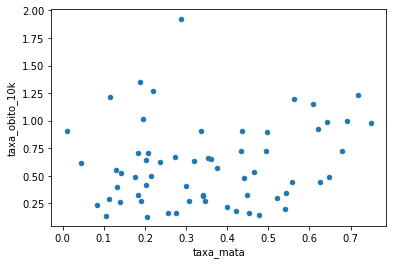

In [32]:
df_taxas_2017 = pd.DataFrame()
df_taxas_2017['taxa_obito_10k'] = df_2017['numero_obitos'] / df_2017['populacao'] * 10_000
df_taxas_2017['taxa_mata'] = df_2017['area_mata'] / df_2017['area_total']
df_taxas_2017.plot(x='taxa_mata',y='taxa_obito_10k',kind='scatter')

In [24]:
get_data = Get_data()
year = 2006
agro_forest_2006 = get_data.agro_forest_municipio(year)
sim_sui_pop_2006 = get_data.sim_suic_pop_municipio(year)

Downloading: 100%|██████████| 102/102 [00:00<00:00, 245.24rows/s]


<AxesSubplot:xlabel='taxa_mata', ylabel='taxa_obito_10k'>

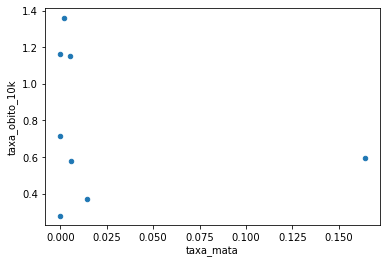

In [34]:
df_2006 = pd.merge(sim_sui_pop_2006, agro_forest_2006, how='left',on='id_municipio')
df_taxas_2006 = pd.DataFrame()
df_taxas_2006['taxa_obito_10k'] = df_2006['numero_obitos'] / df_2006['populacao'] * 10_000
df_taxas_2006['taxa_mata'] = df_2006['area_mata'] / df_2006['area_total']
df_taxas_2006.plot(x='taxa_mata',y='taxa_obito_10k',kind='scatter')

In [28]:
df_2006

,id_municipio,numero_obitos,populacao,area_total,area_mata_natural,area_mata_plantada,area_sistema_agroflorestal,area_mata
0,1200203,6,86725,70376.23,NaN,NaN,NaN,NaN
1,1200252,2,14193,151230.59,NaN,NaN,NaN,NaN
2,1200302,4,39365,235919.47,NaN,1983.00,NaN,NaN
3,1200500,4,33614,343654.33,NaN,293.50,NaN,NaN
4,1200609,4,30711,334290.31,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
97,1100809,2,17346,161666.72,NaN,NaN,NaN,810.25
98,1100924,1,6649,262584.30,NaN,39.75,NaN,NaN
99,1101005,1,18786,139455.45,NaN,NaN,NaN,NaN
100,1101492,1,17610,251018.80,NaN,41.75,NaN,NaN
